# xcp_d vs. nilearn

## xcp_d

1. Censor
2. Detrend
2. Regress
3. Interpolate
4. Filter

## nilearn

1. Interpolate (replace high motion volumes with cubic spline interpolation)
2. Detrend
3. Filter (low- and high-pass butterworth filter)
4. Censor (censor high motion volumes)
5. Regress (remove confounds)
6. ~~standardize~~
7. Interpolate (must be done post hoc)


## Conclusions

1. It might not be good to interpolate censored data if it was filtered before censoring.
2. It might not be good to detrend the BOLD data _after_ censoring (which xcp_d does).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import masking, signal, plotting
import numpy as np

In [2]:
in_file = (
    "/Users/taylor/Documents/datasets/ds003643/derivatives/fmriprep/sub-EN100/func/"
    "sub-EN100_task-lppEN_run-1_desc-preproc_bold.nii.gz"
)
mask = (
    "/Users/taylor/Documents/datasets/ds003643/derivatives/fmriprep/sub-EN100/func/"
    "sub-EN100_task-lppEN_run-1_desc-brain_mask.nii.gz"
)
confounds = (
    "/Users/taylor/Documents/datasets/ds003643/derivatives/fmriprep/sub-EN100/func/"
    "sub-EN100_task-lppEN_run-1_desc-confounds_timeseries.tsv"
)
data = masking.apply_mask(in_file, mask)
df = pd.read_table(confounds)
t_r = 2  # read from json
n_vols, n_voxels = data.shape

nuisance = df[["csf", "white_matter"]].to_numpy()
fd = df["framewise_displacement"].to_numpy()

In [3]:
fd_threshold = 10
bad_vols = fd > fd_threshold
sample_mask = fd <= fd_threshold
print(np.sum(bad_vols))

0


## xcp_d style

In [4]:
xdata_censored = data[sample_mask, :]
xnuisance_censored = nuisance[sample_mask, :]
xdata_cen_den = signal.clean(
    xdata_censored,
    runs=None,
    detrend=False,
    standardize=False,
    sample_mask=None,
    confounds=xnuisance_censored,
    standardize_confounds=True,
    filter=None,
    t_r=None,
)
xdata_cen_den_temp = np.zeros((n_vols, n_voxels), dtype=xdata_cen_den.dtype)
xdata_cen_den_temp[sample_mask, :] = xdata_cen_den
xdata_cen_den_interp = signal._interpolate_volumes(
    xdata_cen_den_temp,
    sample_mask=sample_mask,
    t_r=t_r,
)
xdata_clean = signal.butterworth(
    xdata_cen_den_interp,
    sampling_rate=1/t_r,
    low_pass=0.08,
    high_pass=0.01,
    order=4,
    padtype="constant",
    padlen=n_vols - 1,
)
ximg_clean = masking.unmask(xdata_clean, mask)

## nilearn style

In [5]:
ndata_clean = signal.clean(
    data,
    runs=None,
    detrend=True,
    standardize=False,
    sample_mask=sample_mask,
    confounds=nuisance,
    standardize_confounds=True,
    filter="butterworth",
    t_r=t_r,
    low_pass=0.08,
    high_pass=0.01,
    butterworth__padtype="constant",
    butterworth__padlen=n_vols - 1,
    butterworth__order=4,
)
"""ndata_clean_temp = np.zeros((n_vols, n_voxels), dtype=ndata_cen_den.dtype)
ndata_clean_temp[sample_mask, :] = ndata_cen_den
ndata_clean = signal._interpolate_volumes(
    ndata_clean_temp,
    sample_mask=sample_mask,
    t_r=t_r,
)
"""
nimg_clean = masking.unmask(ndata_clean, mask)

In [6]:
assert ndata_clean.shape == xdata_clean.shape

<ipython-input-7-0b4abc6a4440>:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


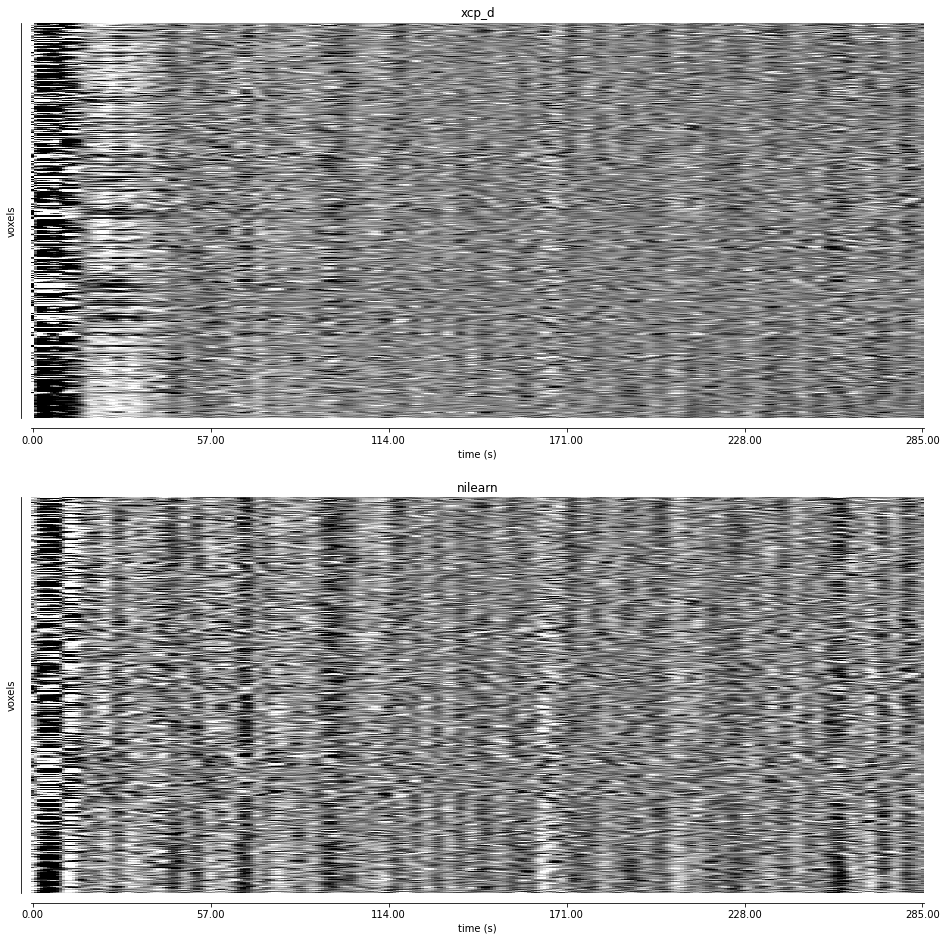

In [7]:
fig, axes = plt.subplots(nrows=2, figsize=(16, 16))

plotting.plot_carpet(ximg_clean, mask, axes=axes[0], figure=fig, title="xcp_d")
plotting.plot_carpet(nimg_clean, mask, axes=axes[1], figure=fig, title="nilearn")
fig.show()

In [8]:
np.max(np.abs(ndata_clean - xdata_clean))

3478.9512

<ipython-input-9-e2edd9b57e12>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


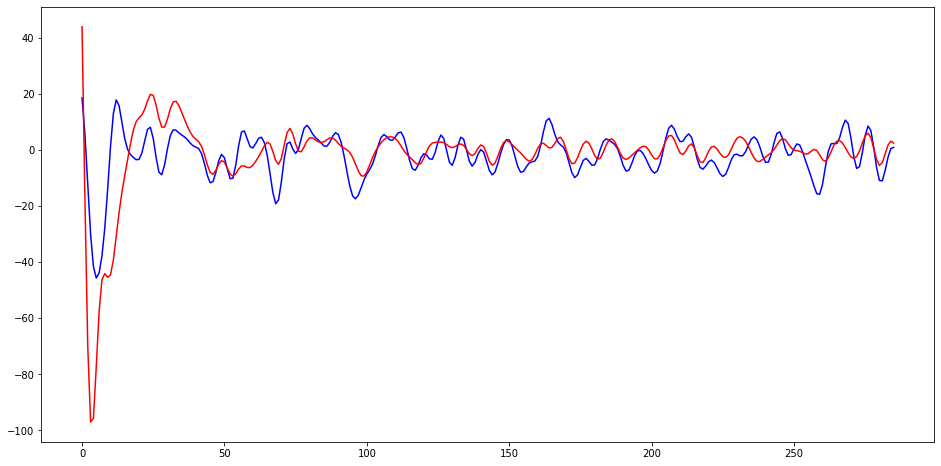

In [9]:
ngs = np.mean(ndata_clean, axis=1)
xgs = np.mean(xdata_clean, axis=1)

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(ngs, color="blue")
ax.plot(xgs, color="red")
fig.show()